In [11]:
import pandas as pd
import requests
import io

df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly_champagne_sales.csv")

print(df.head())

     Month  Sales
0  1964-01   2815
1  1964-02   2672
2  1964-03   2755
3  1964-04   2721
4  1964-05   2946


In [12]:
df.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [14]:
#changing Month to datetime
datetime = pd.to_datetime(df['Month'])
datetime

0     1964-01-01
1     1964-02-01
2     1964-03-01
3     1964-04-01
4     1964-05-01
         ...    
100   1972-05-01
101   1972-06-01
102   1972-07-01
103   1972-08-01
104   1972-09-01
Name: Month, Length: 105, dtype: datetime64[ns]

In [18]:
#making the index be the time value and dropping the 
#not needed Month column
df.index = datetime
df.drop(columns='Month', inplace=True)

In [19]:
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


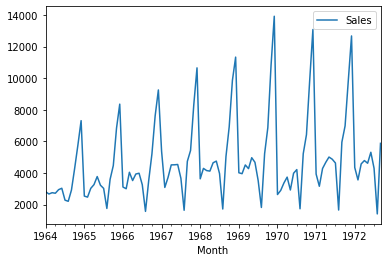

In [35]:
#a quick look for patterns:
df.plot()

It's clear that there is major seasonality and irregularity.

**The weighted rolling mean**

A drawback of the rolling mean approach is that the window has to be strictly defined. In this case, we can take yearly averages but in complex situations like forecasting a stock price, it may be difficult to come up with an exact number. So we take a "weighted rolling mean" (or weighted moving average, WMA for short) where more recent values are given a higher weight. There are several techniques for assigning weights.

A popular one is Exponentially Weighted Moving Average where weights are assigned to all the previous values with an exponential decay factor. This can be implemented in Pandas with .ewm() method.

In [36]:
df.rolling(window=12).sum()

,Sales
Month,
1964-01-01,NaN
1964-02-01,NaN
1964-03-01,NaN
1964-04-01,NaN
1964-05-01,NaN
...,...
1972-05-01,68514.0
1972-06-01,68952.0
1972-07-01,68617.0


In [27]:
# Draw a line plot using nyse and .plot() method 
import matplotlib.pyplot as plt
%matplotlib inline

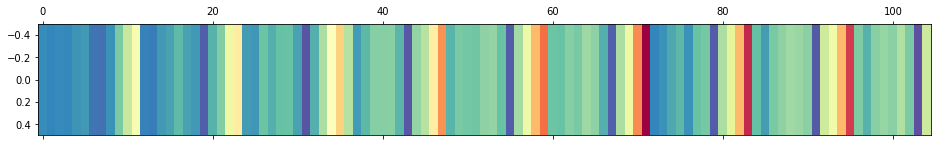

In [29]:
# heatmap for time-series:
time_matrix = df.T
plt.matshow(time_matrix, interpolation=None, aspect='auto', cmap=plt.cm.Spectral_r);

## EDA and Decomposition:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025EFB08A358>]],
      dtype=object)

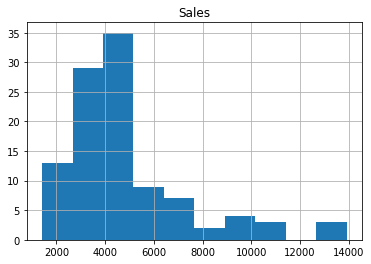

In [80]:
df.hist() 

non-normal distribution... can it be normalized with log-transformation?

(array([ 7.,  2.,  7., 18., 25., 24.,  8.,  4.,  6.,  4.]),
 array([7.25347038, 7.4822028 , 7.71093521, 7.93966763, 8.16840004,
        8.39713246, 8.62586487, 8.85459729, 9.08332971, 9.31206212,
        9.54079454]),
 <a list of 10 Patch objects>)

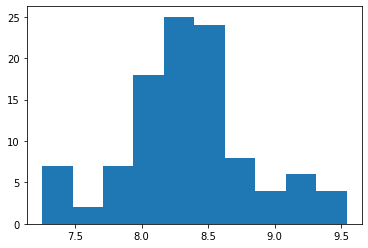

In [79]:
x= df.values
X = np.log(x)
plt.hist(X)


yup

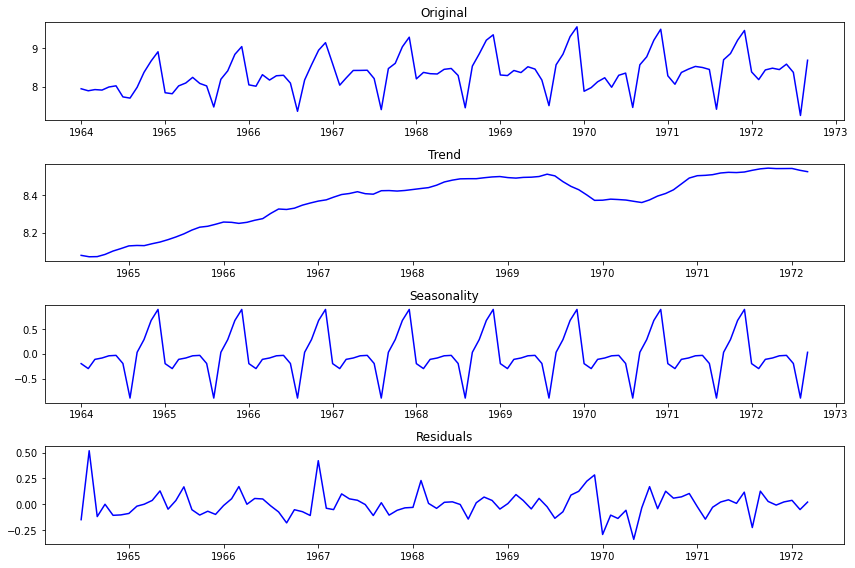

In [67]:
# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(df))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

feats = (np.log(df), trend, seasonal, residual)

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12,8))

ax[0].plot(np.log(df), color='blue')
ax[0].set_title('Original')
ax[1].plot(trend, color='blue')
ax[1].set_title('Trend')
ax[2].plot(seasonal, color='blue')
ax[2].set_title('Seasonality')
ax[3].plot(residual, color='blue')
ax[3].set_title('Residuals')

plt.tight_layout()

In [81]:
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=8.243418, mean2=8.453150
variance1=0.173122, variance2=0.262389


In [84]:
from statsmodels.tsa.stattools import adfuller as af

In [88]:
df_copy = df.copy()

In [90]:
df_copy['Sales_log'] = np.log(df['Sales'])

In [92]:
df_copy.drop('Sales', axis=1, inplace=True)

In [93]:
df_copy.head()

,Sales_log
Month,
1964-01-01,7.942718
1964-02-01,7.890583
1964-03-01,7.921173
1964-04-01,7.908755
1964-05-01,7.988204


In [95]:
result = af(df_copy, autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ValueError: too many values to unpack (expected 2)